### Co Training testing 2

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

### based on https://github.com/jjrob13/sklearn_cotraining/blob/master/sklearn_cotraining/classifiers.py

In [316]:
import numpy as np
import random
import copy
class CoTrainingClassifier(object):
    """
    Organization from https://github.com/jjrob13/sklearn_cotraining
    Algorithm based on "Combining Labeled and Unlabeled Data with Co-Training", Blum and Mitchell, 1998 
    
    Parameters:
    clf - The classifier that will be used in the cotraining algorithm on the view 1 feature set
        (If clf2 is not specified, then the same type of classifier will be used on the second view).

    clf2 - (Optional) A different classifier type can be specified to be used on the X2 feature set
         if desired.

    p - (Optional) The number of positive examples that will be 'labeled' by each classifier during each iteration
        The default is the is determined by the smallest integer ratio of positive to negative samples in L (from paper)

    n - (Optional) The number of negative examples that will be 'labeled' by each classifier during each iteration
    The default is the is determined by the smallest integer ratio of positive to negative samples in L (from paper)

    k - (Optional) The number of iterations
        The default is 30 (from paper)

    u - (Optional) The size of the pool of unlabeled samples from which the classifier can choose
    Default - 75 (from paper)
    """

    def __init__(self, clf, clf2=None, p=-1, n=-1, k=30, u=75):
        
        self.clf1_ = clf

        if clf2 == None:
            self.clf2_ = copy.copy(clf)
        else:
            self.clf2_ = clf2

        #if user only specifies one of n or p, raise an exception
        if (p == -1 and n != -1) or (p != -1 and n == -1):
            raise ValueError('Must supply either both p and n, or neither')

        self.p_ = p
        self.n_ = n
        self.k_ = k
        self.u_ = u

        random.seed(10)
        
        # for testing
        self.partial_error_ = []
        # for testing with training data
        self.partial_train_error_ = []


    def fit(self, X1, X2, y, y_train_full=None, X1_test=None, X2_test=None, y_test=None):
        """
        Description:
        fits the classifiers on the partially labeled data, y.

        Parameters:
        X1 - array-like (n_samples, n_features_1): first set of features for samples
        X2 - array-like (n_samples, n_features_2): second set of features for samples
        y - array-like (n_samples): labels for samples, -1 indicates unlabeled

        """

        # convert to numpy array
        y = np.asarray(y)

        #set the n and p parameters if we need to
        if self.p_ == -1 and self.n_ == -1:
            num_pos = sum(1 for y_i in y if y_i == 1)
            num_neg = sum(1 for y_i in y if y_i == 0)

            n_p_ratio = num_neg / float(num_pos)

            if n_p_ratio > 1:
                self.p_ = 1
                self.n_ = round(self.p_*n_p_ratio)

            else:
                self.n_ = 1
                self.p_ = round(self.n_/n_p_ratio)
        print(self.n_)
        print(self.p_)

        assert(self.p_ > 0 and self.n_ > 0 and self.k_ > 0 and self.u_ > 0)

        #the set of unlabeled samples
        U = [i for i, y_i in enumerate(y) if y_i == -1]

        #we randomize here, and then just take from the back so we don't have to sample every time
        np.random.seed(10)
        np.random.shuffle(U)
        
        #this is U' in paper
        U_ = U[-min(len(U), self.u_):]

        #the samples that are initially labeled
        L = [i for i, y_i in enumerate(y) if y_i != -1]

        #remove the samples in U_ from U
        U = U[:-len(U_)]


        it = 0 #number of cotraining iterations we've done so far

        #loop until we have assigned labels to everything in U or we hit our iteration break condition
        while it != self.k_ and U:
            it += 1

            
            self.clf1_.fit(X1[L], y[L])
            self.clf2_.fit(X2[L], y[L])
            print(len(L))
            ###y_test_new = y_test[U_]

            y1_prob = self.clf1_.predict_log_proba(X1[U_])
            y2_prob = self.clf2_.predict_log_proba(X2[U_])
            
            
#             print(y1_prob)
#             print(y2_prob)
            
            n, p = [], []
            accurate_guesses_h1 = 0
            accurate_guesses_h2 = 0
            wrong_guesses_h1 = 0
            wrong_guesses_h2 = 0
            
            
            #print([np.sort(y1_prob)[:5]])
            for i in (y1_prob[:,0].argsort())[-self.n_:]:
                #if y1_prob[i,0] > 0.5:
                    n.append(i)
#                     if y_test_new[i] == 0:
#                         accurate_guesses_h1 += 1
#                         print("h1 correct class 0")
#                     else:
#                         wrong_guesses_h1 += 1
#                         print("h1 guessed 0 actually " + str(y_test_new[i]))
                 
            #print([(np.sort(y1_prob))[-5:]])
            for i in (y1_prob[:,1].argsort())[-self.p_:]:
                #if y1_prob[i,1] > 0.5:
                    p.append(i)
#                     if y_test_new[i] == 1:
#                         accurate_guesses_h1 += 1
#                         print("h1 correct class 1")
#                     else:
#                         wrong_guesses_h1 += 1
#                         print("h1 guessed 1 actually " + str(y_test_new[i]))

            #print([(np.sort(y2_prob))[:5]])
            for i in (y2_prob[:,0].argsort())[-self.n_:]:
                #if y2_prob[i,0] > 0.5:
                    n.append(i)
#                     if y_test_new[i] == 0:
#                         accurate_guesses_h2 += 1
#                         print("h2 correct class 0")
#                     else:
#                         wrong_guesses_h2 += 1
#                         print("h2 guessed 0 actually " + str(y_test_new[i]))
                    
            #print([(np.sort(y2_prob))[-5:]])
            for i in (y2_prob[:,1].argsort())[-self.p_:]:
                #if y2_prob[i,1] > 0.5:
                    p.append(i)
#                     if y_test_new[i] == 1:
#                         accurate_guesses_h2 += 1
#                         print("h2 correct class 1")
#                     else:
#                         wrong_guesses_h2 += 1
#                         print("h2 guessed 1 actually " + str(y_test_new[i]))


                        
#             print("accurate guesses h1 " + str(accurate_guesses_h1))
#             print("wrong guesses h1" + str(wrong_guesses_h1))
#             print("accurate guesses h2 " + str(accurate_guesses_h2))
#             print("wrong guesses h2" + str(wrong_guesses_h2))
            

            #label the samples and remove the newly added samples from U_
            y[[U_[x] for x in p]] = 1
            y[[U_[x] for x in n]] = 0

            L.extend([U_[x] for x in p])
            L.extend([U_[x] for x in n])

            U_ = [elem for elem in U_ if not (elem in p or elem in n)]

            #add new elements to U_
            add_counter = 0 #number we have added from U to U_
            num_to_add = len(p) + len(n)
            while add_counter != num_to_add and U:
                add_counter += 1
                U_.append(U.pop())
                
            
            # if input testing data as well, find the incrememtal update on accuracy
            if X1_test is not None and X2_test is not None and y_test is not None:
                y_pred = self.predict(X1_test, X2_test)
                self.partial_error_.append(1-accuracy_score(y_test, y_pred))
                y_pred = self.predict(X1, X2)
                self.partial_train_error_.append(1-accuracy_score(y_train_full, y_pred))


            #TODO: Handle the case where the classifiers fail to agree on any of the samples (i.e. both n and p are empty)


        #fit the final model
        self.clf1_.fit(X1[L], y[L])
        self.clf2_.fit(X2[L], y[L])
        
        return (self.partial_train_error_, self.partial_error_)


    #TODO: Move this outside of the class into a util file.
    def supports_proba(self, clf, x):
        """Checks if a given classifier supports the 'predict_proba' method, given a single vector x"""
        try:
            clf.predict_proba([x])
            return True
        except:
            return False
    
    def predict(self, X1, X2):
        """
        Predict the classes of the samples represented by the features in X1 and X2.

        Parameters:
        X1 - array-like (n_samples, n_features1)
        X2 - array-like (n_samples, n_features2)

        
        Output:
        y - array-like (n_samples)
            These are the predicted classes of each of the samples.  If the two classifiers, don't agree, we try
            to use predict_proba and take the classifier with the highest confidence and if predict_proba is not implemented, then we randomly
            assign either 0 or 1.  We hope to improve this in future releases.

        """

        y1 = self.clf1_.predict(X1)
        y2 = self.clf2_.predict(X2)

        proba_supported = self.supports_proba(self.clf1_, X1[0]) and self.supports_proba(self.clf2_, X2[0])

        #fill y_pred with -1 so we can identify the samples in which the classifiers failed to agree
        y_pred = np.asarray([-1] * X1.shape[0])
        num_disagree = 0
        num_agree = 0

        for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
            if y1_i == y2_i:
                y_pred[i] = y1_i
                num_agree += 1
            elif proba_supported:
                y1_probs = self.clf1_.predict_proba([X1[i]])[0]
                y2_probs = self.clf2_.predict_proba([X2[i]])[0]
                sum_y_probs = [prob1 + prob2 for (prob1, prob2) in zip(y1_probs, y2_probs)]
                max_sum_prob = max(sum_y_probs)
                y_pred[i] = sum_y_probs.index(max_sum_prob)
                num_disagree += 1
            else:
                #the classifiers disagree and don't support probability, so we guess
                y_pred[i] = random.randint(0, 1)
                
        print("agree")
        print(num_agree)
        print("disagree")
        print(num_disagree)


        #check that we did everything right
        assert not (-1 in y_pred)

        return y_pred


    def predict_proba(self, X1, X2):
        """Predict the probability of the samples belonging to each class."""
        y_proba = np.full((X1.shape[0], 2), -1)

        y1_proba = self.clf1_.predict_proba(X1)
        y2_proba = self.clf2_.predict_proba(X2)

        for i, (y1_i_dist, y2_i_dist) in enumerate(zip(y1_proba, y2_proba)):
            y_proba[i][0] = (y1_i_dist[0] + y2_i_dist[0]) / 2
            y_proba[i][1] = (y1_i_dist[1] + y2_i_dist[1]) / 2

        _epsilon = 0.0001
        assert all(abs(sum(y_dist) - 1) <= _epsilon for y_dist in y_proba)
        return y_proba

In [317]:
digits = datasets.load_digits()
images_and_labels = list(zip(digits.images, digits.target))


[ 0.          0.          0.33333333  0.86666667  0.6         0.06666667
  0.          0.          0.          0.          0.86666667  1.
  0.66666667  1.          0.33333333  0.          0.          0.2         1.
  0.13333333  0.          0.73333333  0.53333333  0.          0.
  0.26666667  0.8         0.          0.          0.53333333  0.53333333
  0.          0.          0.33333333  0.53333333  0.          0.          0.6
  0.53333333  0.          0.          0.26666667  0.73333333  0.
  0.06666667  0.8         0.46666667  0.          0.          0.13333333
  0.93333333  0.33333333  0.66666667  0.8         0.          0.          0.
  0.          0.4         0.86666667  0.66666667  0.          0.          0.        ]
(360,)


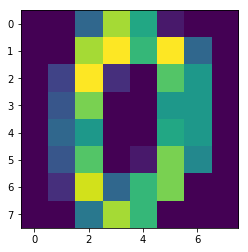

(360,)


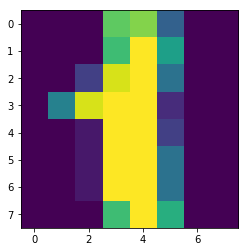

In [385]:
labels_list = list()
images_list = list()
np.random.seed(20)
count = 0
for i, (img,label) in enumerate(images_and_labels):
    if label == 0 or label == 1:
        img2 = np.transpose(np.array(img).reshape(-1,))/np.max(img)
        #img2 = img2 + np.random.normal(scale = 0.075, size=img2.shape)
        images_list.append(img2)
        labels_list.append(label)
        count += 1
images = np.array(images_list)
labels = np.array(labels_list)
print(images[0,:])
print(labels.shape)
plt.figure()
plt.imshow(images[0,:].reshape((8,8)))
plt.show()
print(labels.shape)
plt.figure()
plt.imshow(images[1,:].reshape((8,8)))
plt.show()

In [386]:
# Construct a random second view to pair with this

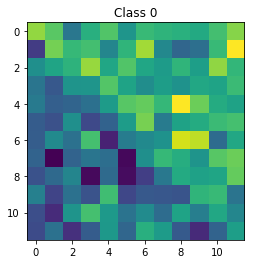

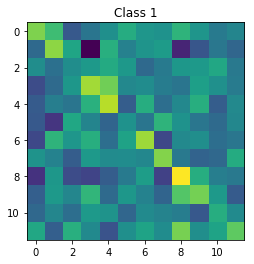

(360, 144)


In [387]:
class0base = np.triu(np.ones(12))
class1base = np.eye(12)
np.random.seed(10)
stdev = .5
# plt.figure()
# plt.imshow(class0base)
# plt.title('Baseline class 0')
# plt.show()
# plt.figure()
# plt.imshow(class1base)
# plt.title('Baseline class 1')
# plt.show()
noisy_set = list()
for i in range(images.shape[0]): #
    if labels[i] == 0:
        temp = np.transpose((class0base + np.random.normal(scale=stdev,size=class0base.shape)).reshape(-1,))
        if i==0:
            plt.figure()
            plt.imshow(temp.reshape((12,12)))
            plt.title("Class 0")
            plt.show()
        noisy_set.append(temp)
    else:
        temp = np.transpose((class1base + np.random.normal(scale=stdev,size=class1base.shape)).reshape(-1,))
        if i==1:
            plt.figure()
            plt.imshow(temp.reshape((12,12)))
            plt.title("Class 1")
            plt.show()
        noisy_set.append(temp)
    
noisy_set = np.array(noisy_set)
print(noisy_set.shape)
    

In [388]:
img_train, img_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=20)
print(img_train.shape)
print(y_test)

(252, 64)
[1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0
 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1
 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0]


In [389]:
noisy_train, noisy_test, y_train, y_test = train_test_split(noisy_set, labels, test_size=0.3, random_state=20)
print(img_train.shape)
print(y_test)

(252, 64)
[1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0
 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1
 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0]


In [390]:
# Verify that both views are sufficient
hh = GaussianNB()
hh.fit(img_train, y_train)
y_pred = hh.predict(img_test)
print("Images accuracy score:")
print(accuracy_score(y_test, y_pred))

hh2 = GaussianNB()
hh2.fit(noisy_train, y_train)
y_pred = hh2.predict(noisy_test)
print("Noisy matrix accuracy score:")
print(accuracy_score(y_test, y_pred))

Images accuracy score:
0.981481481481
Noisy matrix accuracy score:
1.0


In [406]:
# set certain labels to -1
random.seed(6.12)
Lsize = 5
labels_train = y_train.copy()
minus1 = np.arange(0,len(labels_train))
random.shuffle(minus1)
minus1 = minus1[:-Lsize]
labels_train[minus1] = -1

print(labels_train[labels_train != -1])


[1 0 1 0 1]


In [407]:
# Test Co-training
gnb1 = GaussianNB()
gnb2 = GaussianNB()
clf = CoTrainingClassifier(gnb1, gnb2, n=1, p=1, k=100, u=40)
errors_train, errors = clf.fit(img_train, noisy_train, labels_train, y_train, img_test, noisy_test, y_test)
#errors = clf.fit(img_train, noisy_train, labels_train, img_train, noisy_train, y_train)

1
1
5
agree
45
disagree
63
agree
117
disagree
135
9
agree
94
disagree
14
agree
218
disagree
34
13
agree
94
disagree
14
agree
220
disagree
32
17
agree
83
disagree
25
agree
190
disagree
62
21
agree
72
disagree
36
agree
153
disagree
99
25
agree
71
disagree
37
agree
153
disagree
99
29
agree
71
disagree
37
agree
155
disagree
97
33
agree
86
disagree
22
agree
197
disagree
55
37
agree
85
disagree
23
agree
197
disagree
55
41
agree
86
disagree
22
agree
194
disagree
58
45
agree
85
disagree
23
agree
193
disagree
59
49
agree
85
disagree
23
agree
191
disagree
61
53
agree
85
disagree
23
agree
194
disagree
58
57
agree
85
disagree
23
agree
192
disagree
60
61
agree
85
disagree
23
agree
191
disagree
61
65
agree
85
disagree
23
agree
191
disagree
61
69
agree
84
disagree
24
agree
190
disagree
62
73
agree
79
disagree
29
agree
184
disagree
68
77
agree
81
disagree
27
agree
186
disagree
66
81
agree
79
disagree
29
agree
189
disagree
63
85
agree
77
disagree
31
agree
194
disagree
58
89
agree
79
disagree
29
agree
1

In [408]:
# evaluate final co-trained classifier
y_pred = clf.predict(img_test, noisy_test)
print(accuracy_score(y_test, y_pred))

agree
94
disagree
14
0.555555555556


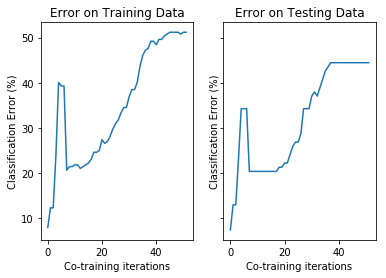

In [409]:
import datetime
time = str(datetime.datetime.now())
time = time.replace(":","_")
time = time.replace(".","_")

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(100*np.array(errors_train))
ax[0].set_title("Error on Training Data")
ax[1].plot(100*np.array(errors))
ax[1].set_title("Error on Testing Data")
ax[0].set_xlabel("Co-training iterations")
ax[0].set_ylabel("Classification Error (%)")
ax[1].set_xlabel("Co-training iterations")
ax[1].set_ylabel("Classification Error (%)")
plt.savefig("Image and Noise data Error" + time + ".png")
plt.show()